# Example 4: Gibbs sampling for original posterior 

In [64]:
# To start this notebook with more than one thread run "export JULIA_NUM_THREADS=4" in the terminal 
# before starting the jupyter notebook

# Ensure that Julia was launched with an appropriate number of threads
println(Threads.nthreads())

4


In [65]:
# Import module. 
using Revise
using PriorNormalization

In [66]:
# Import packages 
using AdaptiveMCMC # for using adaptive MCMC sampling
using ApproxFun # for approximating gammainvccdf by a Chbychev interpolant  
using CairoMakie # for plots 
using Dates # to measure computational time 
using Distributions
using FFTW # for discrete cosine transform 
using FlexiMaps # for log-range  
using ForwardDiff # for AD 
using ImagePhantoms # for CT image 
using JLD2 # for saving and loading results  
using LinearAlgebra # to represent the identity matrix as "I" 
using MIRTjim: jim, prompt # for plotting image 
using Random # for generating random noise 
using StatsBase # for defining customized distributions 
using StatsFuns # for defining customized distributions 
using StatsPlots # for plotting 
using SparseArrays # for efficient storing of the forward operator 
using SpecialFunctions
using Turing # for setting up the model and sampling 
using Optim # for ML and MAP estimation 
using Plots: Plots, plot, plot!, scatter, scatter!, savefig, surface, surface!
using ProgressMeter # to show progress 

In [67]:
# Prepare arguments.  
nr_chains = 4 # number of chains to sample 
nr_samples_raw = 10^5 # number of samples 
thin = 10^2 # Thinning factor; only every thin-th sample is stored
init = "prior" # Initialization option: "MAP", "prior"
nr_samples = Int64( nr_samples_raw/thin )

# Tests: 
# nr_samples_raw = 10^2, thin = 10^0:  & 4s
# nr_samples_raw = 10^3, thin = 10^0:  & 7s
# nr_samples_raw = 10^4, thin = 10^1:  & 63s (1m)
# nr_samples_raw = 10^5, thin = 10^2:  & 19m
# nr_samples_raw = 10^6, thin = 10^3:  &  

1000

## Define the data model 

In [68]:
# Problem parameters 
n = 20 # number of pixes in each direction 
σ² = 1e-2 # noise variance  
Random.seed!(123) # Setting the random seed 

TaskLocalRNG()

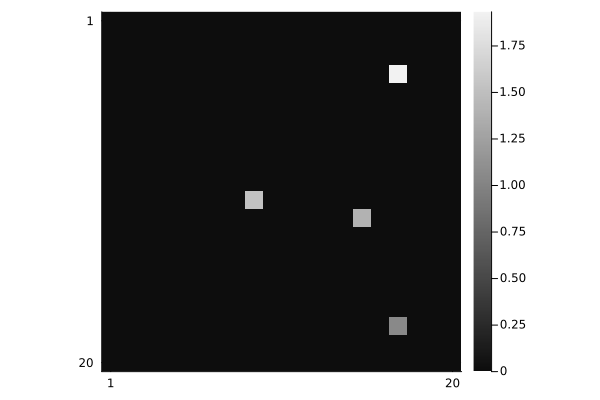

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/impulse_imageRef.pdf"

In [69]:
# Fill image with zeros 
image_ref = shepp_logan(n) 
image_ref .= 0

# Fill 5% of the entries with random numbers between 0 and 1 
nr_support = Int64(ceil( (n^2)*1/100 )) 
coord_support = rand(CartesianIndices(image_ref), nr_support)
values_support = rand(Float64, nr_support) .+ 1
image_ref[coord_support] = values_support

p = jim(image_ref)
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures", 
    "impulse_n$(n)_imageRef.pdf"
)
#savefig(output_filename)

In [70]:
function forward_operator( x )
    n = Int64(sqrt(length(x)))
    X = reshape(x, n, n) 
    Y = FFTW.dct(X)
    Z = Y
    #Z = Y[1:2:end,1:2:end]
    z = Z[:]
    
    return z
end

forward_operator (generic function with 1 method)

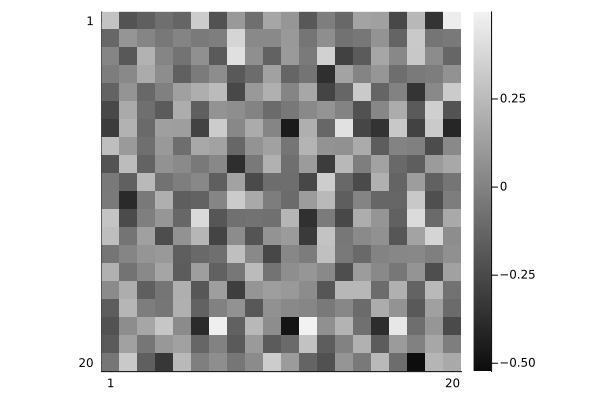

In [71]:
y = forward_operator( image_ref[:] ) 
obsData = y + sqrt(σ²).*randn(length(y))
m = Int64(sqrt(length(y)))
    
image_obs = reshape(obsData, m, m)
p = jim(image_obs)
display(p)

In [72]:
N = n^2
M = length(obsData) 

# Change coordinates to promote sparsity in v = L*u 
forwardOp( x ) = (1/sqrt(σ²)) * forward_operator( x ) 

# Whitening of observational data 
b = (1/sqrt(σ²)) * obsData

400-element Vector{Float64}:
  2.8852735379930277
 -2.108699278108916
 -1.5963443194534173
 -0.8540673827854705
 -1.2900155593819145
  3.266698978321711
 -2.138843660950711
  0.9841282012974863
 -0.8549001347087997
  1.5905261637904005
  0.8720025219925989
 -1.8681149239634625
 -0.19795650346461835
  ⋮
  0.396298123887196
  3.2799753372711518
  1.108234809123376
 -1.3759791180040715
 -2.207967368004505
  0.8102391923102975
 -0.44154620467144856
  2.4052287904527536
 -0.9537772708532144
 -5.237515720165899
  2.233774878528354
  1.6972879497189344

## Select the model: $r=-1$

In [73]:
# Select hyper-hyper-parameters 
model_nr = 4 

# Parameter of of generalized gamma hyper-prior 
r_range = [ 1.0, .5, -.5, -1.0 ]; 
β_range = [ 1.501, 3.0918, 2.0165, 1.0017 ];
ϑ_range = [ 5*10^(-2), 5.9323*10^(-3), 1.2583*10^(-3), 1.2308*10^(-4) ];

# Select hyper-hyper-parameters 
r = r_range[model_nr] # power parameter 
β = β_range[model_nr] # shape parameter 
ϑ = ϑ_range[model_nr] # scale parameter

0.00012308

## Initialization

In [74]:
# Load the MAP estimates 

# MAP estimate of the original posterior 
@load "data/impulse_model$(model_nr)_MAP_original.jld2" θ_MAP x_MAP
# Initialize an empty vector to store the interleaved values
original_MAP = Vector{Float64}(undef, 2*N)
# Interleave τ_MAP and u_MAP
original_MAP[1:2:end-1] .= θ_MAP
original_MAP[2:2:end] .= x_MAP

400-element view(::Vector{Float64}, 2:2:800) with eltype Float64:
  0.0004429965085902933
  2.075040740110167e-5
 -0.0002711131634634728
 -0.0014658476754174888
  0.0004258078281016712
 -0.0001572077971213798
  0.00030882255467424365
 -0.0008463466704327205
 -0.0004780147756801909
  3.5843652176916e-5
  9.229835926432894e-6
 -0.0003469757175749602
 -0.0006457653300246614
  ⋮
  0.0011657887609336848
 -1.6321568153720128e-5
  0.002061856716917581
 -2.8931804572796802e-5
 -0.0004542730180700002
  5.692997973279889e-5
  0.001966166528175249
 -3.5438435854230476e-5
 -0.0006788965810425827
  0.0006093251667298465
 -0.00020242417407238556
 -0.00045683384645377065

In [75]:
## Genrate random samples from the original prior 

original_prior = Array{Float64}(undef, 2*N, nr_chains)
# Generate θ-samples from the gamma distribution
θ_prior_samples = rand(Gamma(β,1), N, nr_chains)
# Transform them into samples of the generalized gamma distribution 
θ_prior_samples = ϑ * θ_prior_samples.^(1/r)

# Generate z-samples from the conditional Gaussian prior 
x_prior_samples = Array{Float64}(undef, N, nr_chains)
# Loop over each chain and each sample to generate the normal samples
for j in 1:nr_chains
    for n in 1:N
        # Standard deviation is sqrt(θ_prior_samples[i, j])
        σ = sqrt(θ_prior_samples[n, j])
        x_prior_samples[n, j] = rand(Normal(0, σ))
    end
    original_prior[1:2:end,j] .= θ_prior_samples[:,j]
    original_prior[2:2:end,j] .= x_prior_samples[:,j]
end

In [76]:
# Choose an initialization for the MCMC chains 
init_param_original = Array{Float64}(undef, 2*N, nr_chains)

# Use MAP estimate 
if init=="MAP"
    # Select the initial set of parameters 
    for j in 1:nr_chains 
        init_param_original[:,j] = original_MAP[:]
    end

    # Select the file names for saving the later MCMC results 
    # Original model 
    filename_original = joinpath(
        "data/impulse_n$(n)_model$(model_nr)_mcmc_initMAP_Gibbs_original_samples$(nr_samples_raw)_thin$(thin)_chains$(nr_chains).jld2"
    )

# Use random prior samples 
elseif init=="prior"
    # Select the initial set of parameters 
    for j in 1:nr_chains 
        init_param_original[:,j] = original_prior[:,j]
    end

    # Select the file names for saving the later MCMC results 
    # Original model 
    filename_original = joinpath(
        "data/impulse_n$(n)_model$(model_nr)_mcmc_initPrior_Gibbs_original_samples$(nr_samples_raw)_thin$(thin)_chains$(nr_chains).jld2"
    )

# Throw an error if none of the available options is provided
else
    error("Invalid initialization option provided: $init. Please choose either 'MAP' or 'prior'.")
end

"data/impulse_n20_model4_mcmc_initPrior_Gibbs_original_samples100000_thin100_chains4.jld2"

## Gibbs sampling

In [77]:
N = n^2                    # dimension of the domain
I_N = Matrix(I, N, N)      # N×N identity
# Apply forward_op to each column of the identity and hcat the results
F = hcat([forwardOp(I_N[:, i]) for i in 1:N]...)

400×400 Matrix{Float64}:
 0.5          0.5         0.5           0.5        …   0.5         0.5
 0.704927     0.687569    0.653281      0.602908      -0.687569   -0.704927
 0.698401     0.630037    0.5           0.32102        0.630037    0.698401
 0.687569     0.537688    0.270598     -0.055479      -0.537688   -0.687569
 0.672499     0.415627    3.92523e-17  -0.415627       0.415627    0.672499
 0.653281     0.270598   -0.270598     -0.653281   …  -0.270598   -0.653281
 0.630037     0.110616   -0.5          -0.698401       0.110616    0.630037
 0.602908    -0.055479   -0.653281     -0.537688       0.055479   -0.602908
 0.572061    -0.218508   -0.707107     -0.218508      -0.218508    0.572061
 0.537688    -0.369462   -0.653281      0.165071       0.369462   -0.537688
 0.5         -0.5        -0.5           0.5        …  -0.5         0.5
 0.459229    -0.602908   -0.270598      0.687569       0.602908   -0.459229
 0.415627    -0.672499    0.0           0.672499      -0.672499    0.4156

In [78]:
# Define the Gibbs sampling function
function gibbs_sampler(θ_init, iterations, F, y, r, β, ϑ)
    M, N = size(F) 
    Ft = transpose(F)
    FtF = Ft*F
    Fty = Ft*y
    
    # Initialize latent variables and parameters
    z = randn(N)  # Initial guess for u
    θ = θ_init

    # Preallocate space to store samples
    samples_z = zeros(iterations, N)
    samples_θ = zeros(iterations, N)

    for i in 1:iterations
        
        # Step 1: Sample z | y, θ
        v1 = randn(M)
        v2 = randn(N) 
        w = Ft*v1 + Diagonal( θ.^(-1/2) )*v2
        C = FtF + Diagonal( θ.^(-1) )
        rhs = Fty + w
        z = C\rhs

        # Step 2: Sample θ | y, z
        for n in 1:N
            θ[n] = rand( InverseGamma(β+0.5, ϑ+0.5*(z[n]^2) ) )
        end

        # Store samples
        samples_z[i, :] = z
        samples_θ[i, :] = θ
    end

    return samples_θ, samples_z
end

gibbs_sampler (generic function with 1 method)

In [79]:
# Initialize
nr_parameters = 2*N
Theta_init = zeros(Float64, N, nr_chains)
Theta = zeros(Float64, nr_samples_raw, N, nr_chains)
Z = zeros(Float64, nr_samples_raw, N, nr_chains)
chn_values = zeros(Float64, nr_samples, 2*N, nr_chains)

# Start the wall clock timer
wall_start = now()

# Use multiple threads. 
@showprogress Threads.@threads for j in 1:nr_chains   
    
    # Initilization 
    Theta_init[:,j] = init_param_original[1:2:end-1,j]
    
    # Generate samples
    Theta[:,:,j], Z[:,:,j] = gibbs_sampler(
        Theta_init[:,j], # initilization 
        nr_samples_raw, # number of samples 
        F, y, r, β, ϑ # data and prior model parameters 
    )
    
    # Store values 
    
    chn_values[:,1:2:end-1,j] = Theta[1:thin:nr_samples_raw,:,j]
    chn_values[:,2:2:end,j] = Z[1:thin:nr_samples_raw,:,j]
    
    # Clear memory after each chain
    GC.gc()
end

# End the wall clock timer
wall_end = now()
wall_duration_ms = wall_end - wall_start
# Convert wall duration to seconds
wall_duration_original = Dates.value(wall_duration_ms) / 1000

# Define the parameter names (θ[1], z[1], θ[2], z[2], ...)
param_names_θ = [string("θ[", i, "]") for i in 1:N ]
param_names_z = [string("x[", i, "]") for i in 1:N ]

# Interleave θ and z names
param_names = Vector{String}(undef, nr_parameters)
param_names[1:2:end-1] .= param_names_θ
param_names[2:2:end] .= param_names_z

# Create the Chains object
chn_original = Chains(chn_values, Symbol.(param_names));

# Free the memory occupied by chn_values
chn_values = nothing
GC.gc()  # Optionally trigger garbage collection manually

Progress: 100%|█████████████████████████████████████████| Time: 0:19:04


In [80]:
# Save the MCMC chain and computational time
@save filename_original chn_original wall_duration_original

# Multivariate potential scale reduction factor (MPSRF) 
# To check convergence: Should be below 1.1

#gelmandiag_multivariate(chn_original)

## Compute and save different statistics

In [81]:
# Compute statistics for the x-samples
x_mean_original = [mean( get(chn_original, :x).x[i] ) for i in 1:N]
x_std_original = [std( get(chn_original, :x).x[i] ) for i in 1:N]
x_var_original = [var( get(chn_original, :x).x[i] ) for i in 1:N]
x_upper_quantile_original = [quantile( vec(get(chn_original, :x).x[i]), 0.95 ) for i in 1:N]  # 95% quantile

# Compute statistics for the ω-samples
theta_mean_original = [mean( get(chn_original, :θ).θ[i] ) for i in 1:N]
theta_std_original = [std( get(chn_original, :θ).θ[i] ) for i in 1:N]
theta_var_original = [var( get(chn_original, :θ).θ[i] ) for i in 1:N]
theta_upper_quantile_original = [quantile( vec(get(chn_original, :θ).θ[i]), 0.95 ) for i in 1:N]  # 95% quantile

400-element Vector{Float64}:
 0.0019721970428442544
 0.0019267050869563927
 0.00197760016043356
 0.001998551060351013
 0.0020815778157799053
 0.0018522714637802516
 0.0017544816268525464
 0.001988105933525051
 0.0017666303631850536
 0.002159000497502085
 0.0018327365761831354
 0.001999236667955919
 0.002064347943237532
 ⋮
 0.0019883109756388038
 0.0019619284393928267
 0.00179761808452763
 0.0018331952100504839
 0.0021052093446282407
 0.002023112276470815
 0.0016905663989926498
 0.002003447247535167
 0.0017296360044897964
 0.0018866701999887383
 0.0019391095821053137
 0.0019597750439992673

In [82]:
# Save statistics 
filename = joinpath(
        "data/impulse_n$(n)_model$(model_nr)_statistics_$(init)_Gibbs_original_samples$(nr_samples_raw)_thin$(thin)_chains$(nr_chains).jld2"
    )
@save filename x_mean_original x_std_original x_var_original x_upper_quantile_original theta_mean_original theta_std_original theta_var_original theta_upper_quantile_original

In [83]:
wall_duration_original

1145.086